# Import Lib

In [1]:
# Import the libraries
import tensorflow as tf
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize
import solve_cudnn
solve_cudnn.solve_cudnn_error()
figsize(15, 7) 

1 Physical GPUs, 1 Logical GPUs


# Cuda Error

# Utils

In [2]:
def read_data(path,fill_zero=False):
    df = pd.read_csv(path, sep=',', parse_dates={'dt':['Datetime']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'], index_col='dt')

    df = df.reindex(index=df.index[::-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    for j in range(df.shape[1]):  
        
        if fill_zero:
        #
            df.iloc[:,j]=df.iloc[:,j].fillna(0)
        else:
            df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    # another sanity check to make sure that there are not more any nan
    print(df.isnull().sum())
    print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        plt.plot(Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], y=0.80, loc='right')
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group):
    plt.matshow(df.iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_original', size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [3]:
def gen_dataset(data,y_column_list,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, :])
        y_train.append(data[i:i+y_window_size, y_column_list ])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))
    
    if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    
    #Record training data index
    data_index = data.shape[0]
    feb_index = data.loc['2021-02'].index.shape[0]
    
    #Y Columns
    y_column=[0,1,2,3,4,5,6,7]
    

    
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data_scaled = scaler.fit_transform(data)     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0,1))
        data_scaled = scaler.fit_transform(data)     

    #training-test split
    training_set = data_scaled[:feb_index,:]
    testing_set = data_scaled[feb_index:,:]
    print("Train set:{}".format(training_set.shape))
    print("Test set:{}".format(testing_set.shape))
    
    #generate dataset
    train_X,train_y = gen_dataset(training_set,y_column,X_win_size,y_win_size)
    test_X,test_y = gen_dataset(testing_set,y_column,X_win_size,y_win_size)

    #return  
    
    return train_X,train_y,test_X,test_y,scaler,data_scaled,scaler.get_params()

# Training Proccess

In [5]:
df = read_data(path=r'E:\Server_mantain\Spark_test\dataset\Zabbix_monitor_SB\Concate_OPLS_PW.csv',fill_zero=True)

1V_Memory_usage    0
2V_Memory_usage    0
3V_Memory_usage    3
4V_Memory_usage    2
1V_CPU_usage       0
2V_CPU_usage       0
3V_CPU_usage       3
4V_CPU_usage       2
dtype: int64
1V_Memory_usage    0
2V_Memory_usage    0
3V_Memory_usage    0
4V_Memory_usage    0
1V_CPU_usage       0
2V_CPU_usage       0
3V_CPU_usage       0
4V_CPU_usage       0
dtype: int64
                     1V_Memory_usage  2V_Memory_usage  3V_Memory_usage  \
dt                                                                       
2021-02-08 17:09:00           7.5909           5.4956           0.0000   
2021-02-08 17:12:00           7.5795           5.4926           0.0000   
2021-02-08 17:15:00           7.5594           5.4660           0.0000   
2021-02-08 17:18:00           7.5794           5.4839           6.0396   
2021-02-08 17:21:00           7.5564           5.5077           6.0263   

                     4V_Memory_usage  1V_CPU_usage  2V_CPU_usage  \
dt                                                 

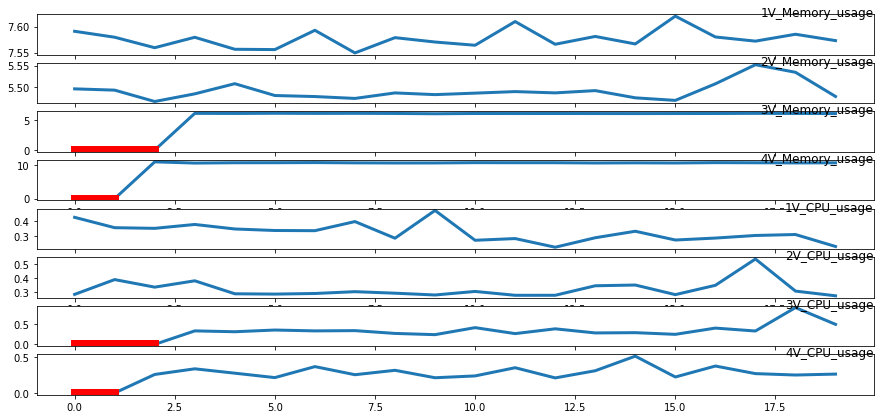

In [18]:
draw_trend(df,[0,1,2,3,4,5,6,7],20)

# Tsfresh analysis

In [6]:
#@title 預設標題文字
X_WIN = 32
Y_WIN = 1
SCALE_MODE = 'robust'


X_train,y_train,X_test,y_test,scaler,df_scale,param = data_scaling(df,X_WIN,Y_WIN,mode=SCALE_MODE)

Mode:robust

Train set:(9735, 8)
Test set:(4663, 8)
Gen data info:
X_data_shape:(9702, 32, 8)
y_data_shape:(9702, 8)


Gen data info:
X_data_shape:(4630, 32, 8)
y_data_shape:(4630, 8)




In [9]:
from pickle import dump

dump(scaler, open('scaler.pkl', 'wb'))

In [28]:
df_scale

array([[-0.05803357, -1.08906084, -2.20360892, ..., -0.58602151,
        -2.76463184, -1.86123786],
       [-0.07170264, -1.09512972, -2.20360892, ...,  0.21812596,
        -2.76463184, -1.86123786],
       [-0.09580336, -1.14894047, -2.20360892, ..., -0.19201229,
        -2.76463184, -0.64490464],
       ...,
       [-1.8646283 , -1.45764426, -0.97115231, ...,  9.72043011,
         0.23599748,  0.48999649],
       [-1.89100719, -0.75830678, -0.97339951, ...,  0.66973886,
        -0.28823159,  0.04024804],
       [-1.7440048 , -1.59115966, -0.97319335, ..., -0.14746544,
        -0.81183134,  0.8002808 ]])

In [8]:
def concate_data(data):

    mem_data = np.concatenate([data[:,:,0],data[:,:,1],data[:,:,2],data[:,:,3]]).reshape(-1,X_WIN,1)
    cpu_data = np.concatenate([data[:,:,4],data[:,:,5],data[:,:,6],data[:,:,7]]).reshape(-1,X_WIN,1)
    return np.concatenate([mem_data,cpu_data],axis=2)

X_train = concate_data(X_train)
X_test = concate_data(X_test)

In [9]:
def model_chk(path):
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)
    
    print("checkpoint save in {}".format(path))
    
    return checkpoint

In [17]:
import AE_Conv
import AE_TCN
import importlib
importlib.reload(AE_Conv)
importlib.reload(AE_TCN)

conv_autoencoder = AE_Conv.conv_autoencoder(X_train.shape[1],X_train.shape[2])
tcn_autoencoder = AE_TCN.tcn_autoencoder(X_train.shape[2])

history_convae = conv_autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=2    
)
save_model(conv_autoencoder,"conv_ae.h5")
history_tcnae = tcn_autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    verbose=2
)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 128)           1920      
_________________________________________________________________
dropout (Dropout)            (None, 16, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             57408     
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 16, 64)            28736     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 32, 128)           57472     
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 32, 2)             1

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
tcn-enc (TCN)                (None, None, 20)          73060     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 8)           168       
_________________________________________________________________
average_pooling1d (AveragePo (None, None, 8)           0         
_________________________________________________________________
activation (Activation)      (None, None, 8)           0         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, None, 8)           0         
_________________________________________________________________
tcn-dec (TCN)                (None, None, 20)          75580 

AttributeError: 'TCNAE' object has no attribute 'outputs'

In [24]:
conv_pre = conv_autoencoder.predict(X_test)
tcn_pre = tcn_autoencoder.predict(X_test)

In [45]:
def concat_pre_data(predict,test):
    
    pre_list = []
    test_list = []
    for i in range(predict.shape[0]):
        pre_list.append(np.concatenate([predict[i],predict[i],predict[i],predict[i]],axis=1)) 
        test_list.append(np.concatenate([test[i],test[i],test[i],test[i]],axis=1)) 
    
    print("predict data shape:{}".format(np.array(pre_list).shape))
    print("test data shape:{}".format(np.array(test_list).shape))

    x_hat = np.array(pre_list)
    x = np.array(test_list)

    x_hat = scaler.inverse_transform(x_hat.reshape(-1,x_hat.shape[-1]))
    x = scaler.inverse_transform(x.reshape(-1,x.shape[-1]))

    return x_hat,x

x_hat,x = concat_pre_data(tcn_pre,X_test)

print(x_hat.shape)
print(x.shape)


predict data shape:(18520, 32, 8)
test data shape:(18520, 32, 8)
(592640, 8)
(592640, 8)


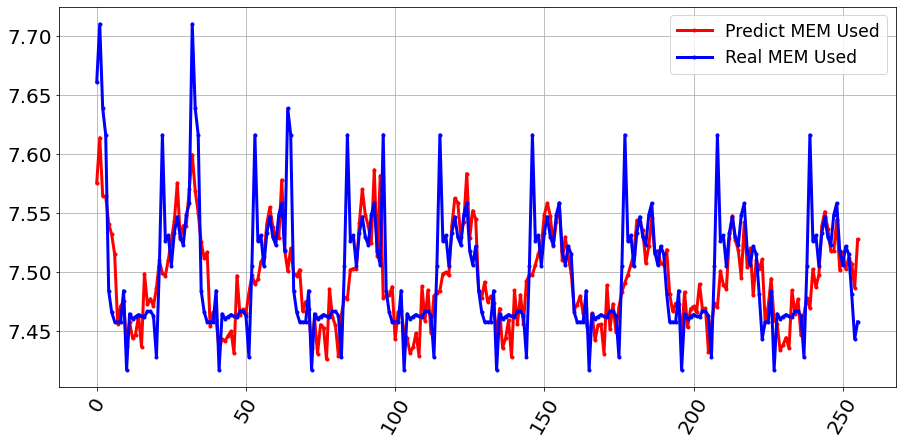

In [46]:
plt.plot(x_hat[:,0].flatten()[:256],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
plt.plot(x[:,0].flatten()[:256],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
plt.xticks(fontsize=20,rotation=60)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize='xx-large')
#plt.title('Predicted values and actual values on test data',fontsize=20)
plt.show()

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_score(y_real,y_hat,model_name):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    MAPEScore = mean_absolute_percentage_error(y_real,y_hat)
        
    print("Model,MAE,RMSE,MAPE")
    print("{},{},{},{}".format(model_name,round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)))
    
    
    return round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)

MAE,RMSE,MAPE = cal_score(x,x_hat,"Conv")
MAE,RMSE,MAPE = cal_score(x,x_hat,"TCN")

Conv
MAE:0.15
RMSE:0.527
MAPE:4.775


In [49]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_score(y_real,y_hat):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    MAPEScore = mean_absolute_percentage_error(y_real,y_hat)

    print("Model,MAE,RMSE,MAPE")
    print("TCN,{},{},{}".format(round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)))
    
    return round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)

MAE,RMSE,MAPE = cal_score(x,x_hat)




Model,MAE,RMSE,MAPE
TCN,0.086,0.253,3.448


In [35]:
model.save("SIMPLE_AE.h5")

In [66]:
import AE_VAE
importlib.reload(AE_VAE)

encoder,decoder,vae = AE_VAE.build_VAE(X_train.shape[1],X_train.shape[2],2)
vae.fit(X_train, epochs=50, batch_size=128)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32, 8)]      0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 16, 32)       800         input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_16 (MaxPooling1D) (None, 8, 32)        0           conv1d_34[0][0]                  
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 4, 16)        1552        max_pooling1d_16[0][0]           
____________________________________________________________________________________________

ValueError: in user code:

    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    e:\Server_mantain\Spark_test\AE_VAE.py:44 train_step
        reconstruction = self.decoder(z)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv1d_37 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, None, 2)


# Run if new training proccess

In [4]:
import os
data_root_path = "E:\Server_mantain\Spark_test\dataset\Zabbix_monitor_SB\concate_with_disk"
data5v_path = os.path.join(data_root_path,"predict_data5V.csv")
data6v_path = os.path.join(data_root_path,"predict_data6V.csv")
data5v = read_data(data5v_path,fill_zero=True)
data6v = read_data(data6v_path,fill_zero=True)

host                   0
CPU utilization (%)    0
Memory used  (%)       1
dtype: int64
host                   0
CPU utilization (%)    0
Memory used  (%)       0
dtype: int64
                                host  CPU utilization (%)  Memory used  (%)
dt                                                                         
2021-06-22 18:41:00  TWKHH01OPTIPW5V              19.8383            0.0000
2021-06-22 18:44:00  TWKHH01OPTIPW5V              18.7174           18.9454
2021-06-22 18:47:00  TWKHH01OPTIPW5V               1.8868           21.0194
2021-06-22 18:50:00  TWKHH01OPTIPW5V              11.0442           17.0870
2021-06-22 18:53:00  TWKHH01OPTIPW5V               2.0538           13.7514
host                   0
CPU utilization (%)    0
Memory used  (%)       0
dtype: int64
host                   0
CPU utilization (%)    0
Memory used  (%)       0
dtype: int64
                                host  CPU utilization (%)  Memory used  (%)
dt                                      

In [7]:
data_list = []

lag = 1
for i in range(0,data5v.shape[0]-lag,lag):
    data_list.append(data5v[i:i+100])




                                host  CPU utilization (%)  Memory used  (%)
dt                                                                         
2021-06-22 18:41:00  TWKHH01OPTIPW5V              19.8383            0.0000
2021-06-22 18:44:00  TWKHH01OPTIPW5V              18.7174           18.9454
2021-06-22 18:47:00  TWKHH01OPTIPW5V               1.8868           21.0194
2021-06-22 18:50:00  TWKHH01OPTIPW5V              11.0442           17.0870
2021-06-22 18:53:00  TWKHH01OPTIPW5V               2.0538           13.7514
...                              ...                  ...               ...
2021-06-22 23:26:00  TWKHH01OPTIPW5V               1.9385           13.6381
2021-06-22 23:29:00  TWKHH01OPTIPW5V               2.3541           13.6668
2021-06-22 23:32:00  TWKHH01OPTIPW5V               1.9646           13.6491
2021-06-22 23:35:00  TWKHH01OPTIPW5V               2.4252           13.6775
2021-06-22 23:38:00  TWKHH01OPTIPW5V              15.0959           13.6250

[100 rows x